In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
%matplotlib inline

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

print(f'TF version {tf.__version__}')
print(f'TFP version {tfp.__version__}')

%config InlineBackend.figure_format = 'retina'
sns.set_context('talk')
sns.set_style('darkgrid')

TF version 2.3.0
TFP version 0.11.1


In [4]:
#@title Utility functions
def format_trace(states, var_name, chain_dim=None):
    if chain_dim is None:
        # chainが１つだと明示するためaxisを追加
        trace = {k: v[tf.newaxis].numpy() for k, v in zip(var_name, states)}
    else:
        # axis0がchainの次元になるようにする
        trace = {k: np.swapaxes(v.numpy(), chain_dim, 0) for k, v in zip(var_name, states)}

    return az.from_dict(trace)


def init_random(shape, n_chains=1, r=2):
    """Stanにならい、Uniform(-2, 2)で初期化する
    """
    if n_chains == 1:
        return tf.random.uniform(shape, -r, r)
    else:
        return tf.random.uniform([n_chains,] + shape, -r, r)

Text(0.5, 0, 'Year')

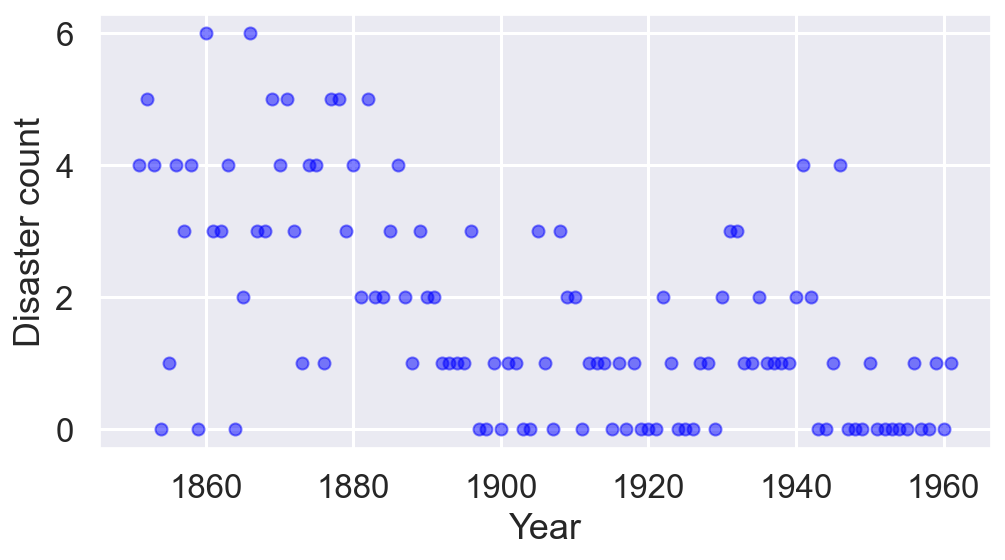

In [5]:
disaster_data = np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                           3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                           2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                           1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                           0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                           3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                           0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
years = np.arange(1851, 1962)

plt.figure(figsize=(8, 4))
plt.plot(years, disaster_data, "o", color='b', markersize=6, alpha=0.5)
plt.ylabel("Disaster count")
plt.xlabel("Year")

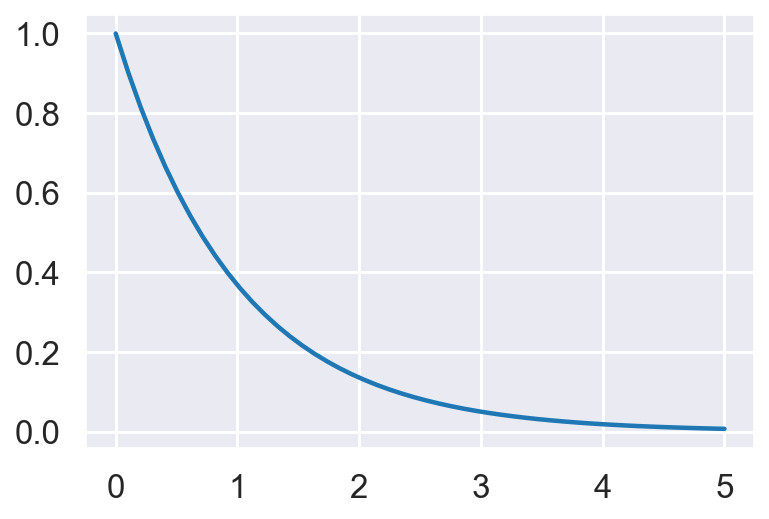

In [7]:
#参考指数分布

exp = tfd.Exponential(rate=1)
xx = np.linspace(0, 5)
plt.plot(xx, exp.prob(xx))

In [18]:
Root = tfd.JointDistributionCoroutine.Root


def model():
    e = yield Root(tfd.Exponential(rate=1.))
    l = yield Root(tfd.Exponential(rate=1.))
    s = yield Root(tfd.Uniform(0., high=len(years)))
    d_t = yield tfd.Independent(
        tfd.Poisson(rate=tf.where(np.arange(len(years)) < s, e, l)),
        reinterpreted_batch_ndims=1
    )
    
    
# 複数チェーンのMCMCを実行しようとすると、s, e, lが２次元になるため、tf.where内のshapeが合わずエラーになる。
# tf.newaxisなどを用いて、バッチ処理に対応できるようにする必要がある。
# まだexperimentalのようだが、AutoBatchedを使えば自動的にモデルをベクトル化してくれる。


joint = tfd.JointDistributionCoroutineAutoBatched(model)


def unnormalized_log_posterior(e, l , s):
    return joint.log_prob(e, l, s, disaster_data)

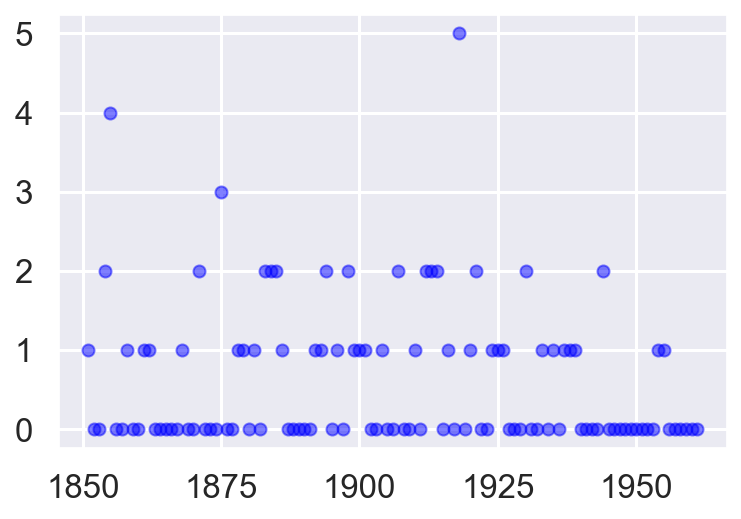

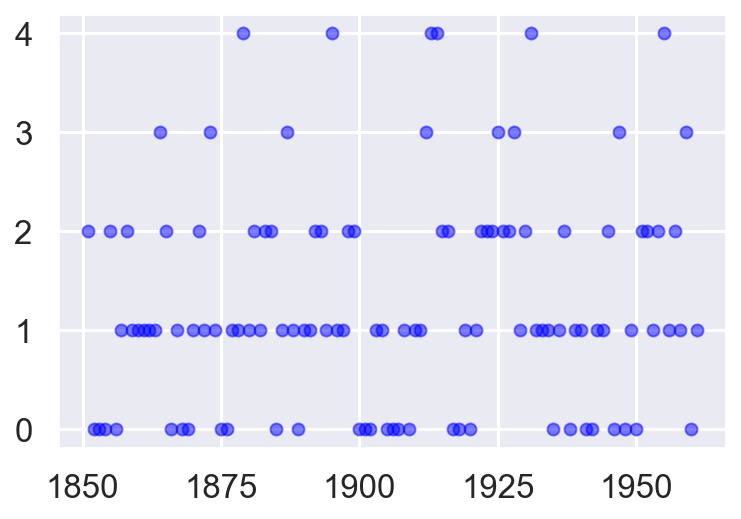

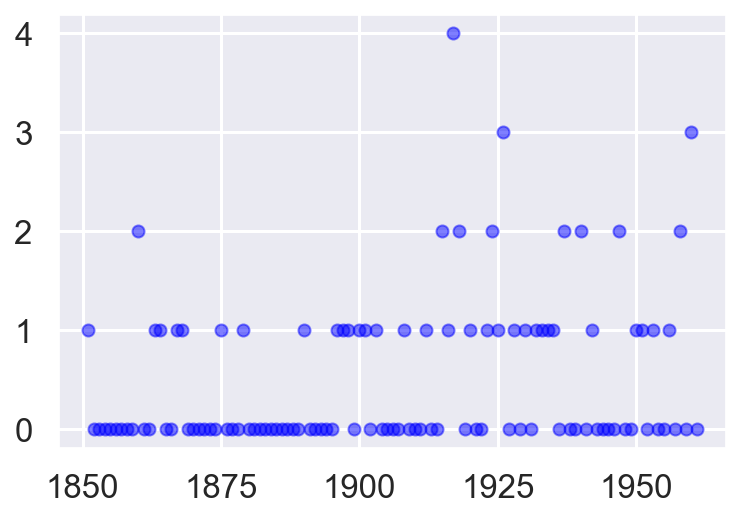

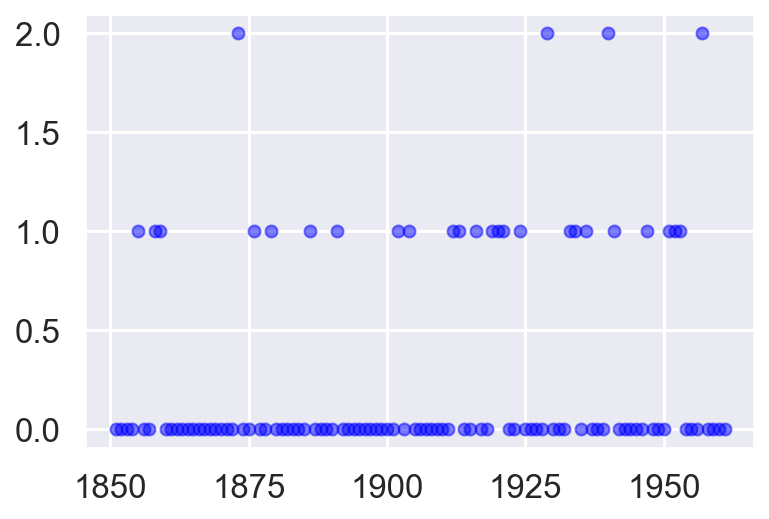

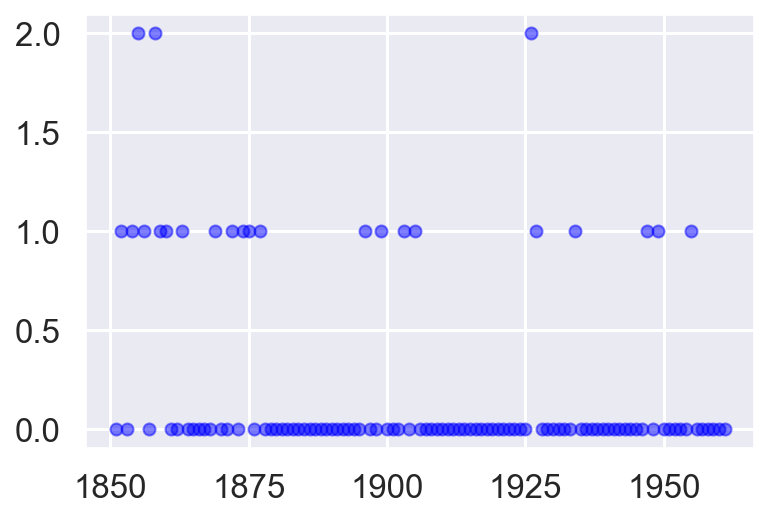

In [15]:
#事前分布を用いたシミュレーション

d_t_samples = joint.sample(5)[-1]

for d_t in d_t_samples:
    plt.figure()
    plt.plot(years, d_t, "o", color="b", markersize=6, alpha=0.5)

In [21]:
%%time 
num_results = 10000
num_burnin_steps = 3000



@tf.function(autograph=False, experimental_compile=True)

def do_sampling():
    kernel = tfp.mcmc.TransformedTransitionKernel(
        inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn = unnormalized_log_posterior,
            step_size=0.1,
            num_leapfrog_steps=5),
        #パラメータの制約を満たすように、bijectorで変換する
         bijector=[
             tfb.Softplus(),
             tfb.Softplus(),
             tfb.Sigmoid(low=0, high=tf.cast(len(years), dtype=tf.float32))
         ])
    
    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel = kernel,
        num_adaptation_steps=int(0.8 * num_burnin_steps))
    
    states = tfp.mcmc.sample_chain(
        num_results = num_results,
        num_burnin_steps = num_burnin_steps,
        current_state = [
            tf.random.uniform([3], 1, 3, name = "init_early_disaster_rate"),
            tf.random.uniform([3], 1, 3, name = "init_late_disaster_rate"),
            tf.random.uniform([3], 0, 3, name = "init_switchpoint")
        ],
        kernel = kernel
    )
    
    return states

states, kernel_results = do_sampling()

accept_rate = kernel_results.inner_results.inner_results.is_accepted.numpy().mean(axis=0)
print('Acceptance rate: {:.1%}, {:.1%}, {:.1%}'.format(*accept_rate))

/Users/imutayuji/opt/anaconda3/envs/brave/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


Acceptance rate: 71.6%, 72.0%, 72.4%
CPU times: user 7.1 s, sys: 81.3 ms, total: 7.19 s
Wall time: 7.2 s


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
e,3.106,0.275,2.626,3.654,0.020,0.014,185.0,185.0,186.0,252.0,1.01
l,0.946,0.122,0.729,1.181,0.006,0.005,352.0,352.0,352.0,886.0,1.01
s,39.381,2.468,35.001,43.999,0.112,0.080,483.0,477.0,517.0,609.0,1.00


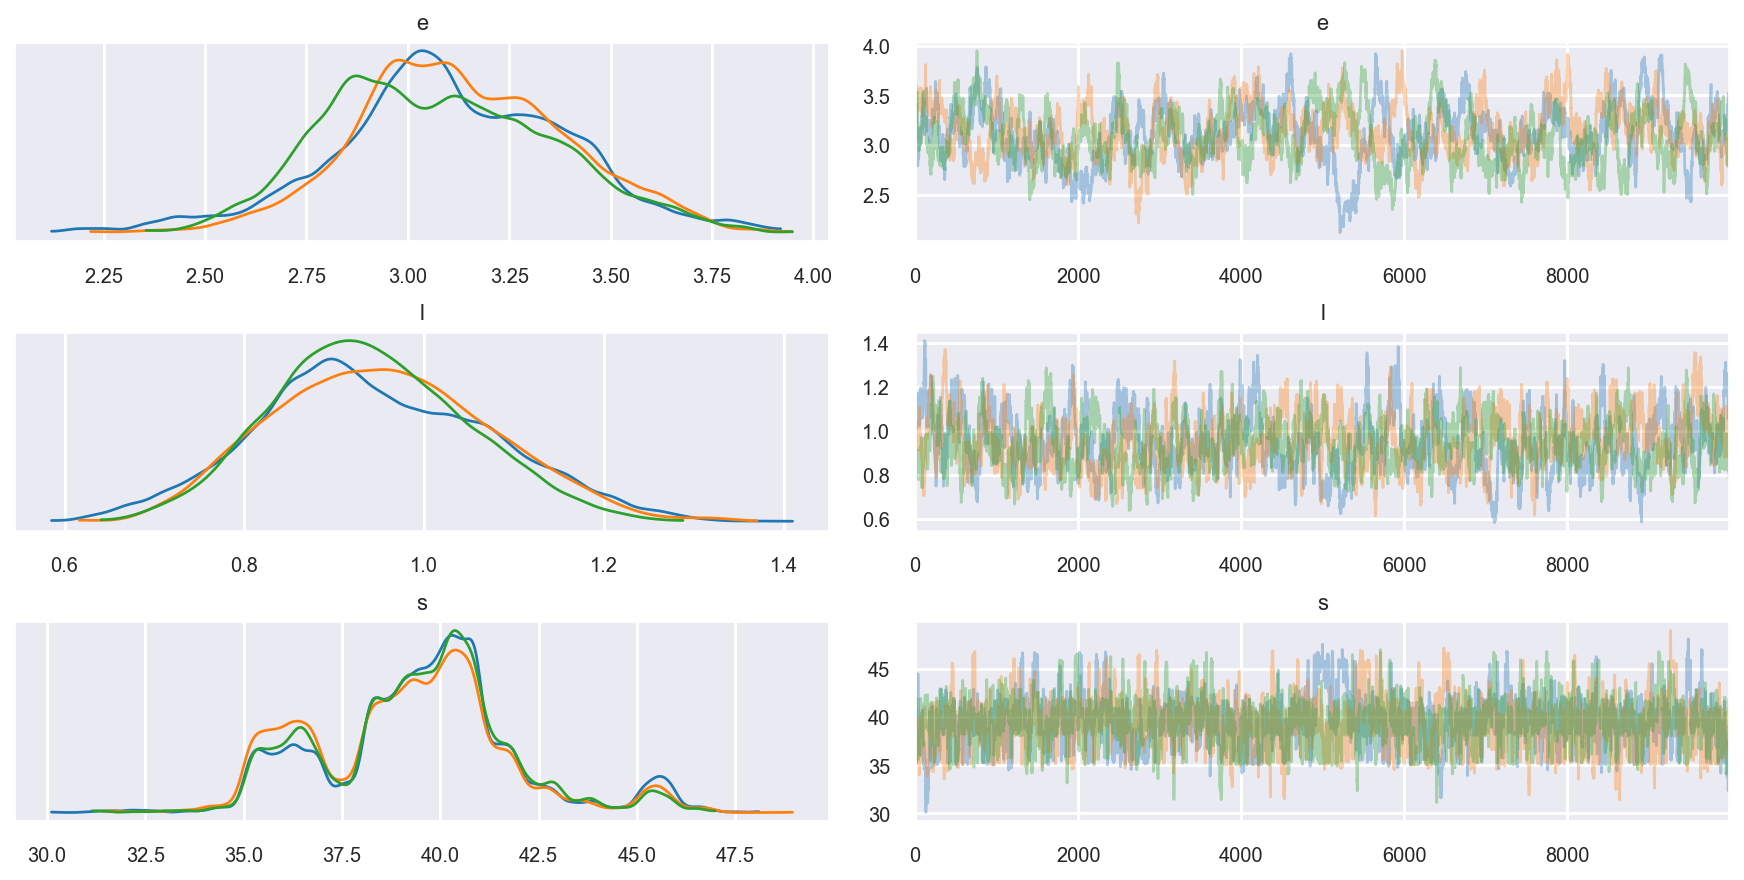

In [23]:
var_name = ["e", "l", "s"]

trace = format_trace(states, var_name, chain_dim=1)
az.plot_trace(trace)

az.summary(trace)

array([<AxesSubplot:title={'center':'e'}>,
       <AxesSubplot:title={'center':'l'}>,
       <AxesSubplot:title={'center':'s'}>], dtype=object)

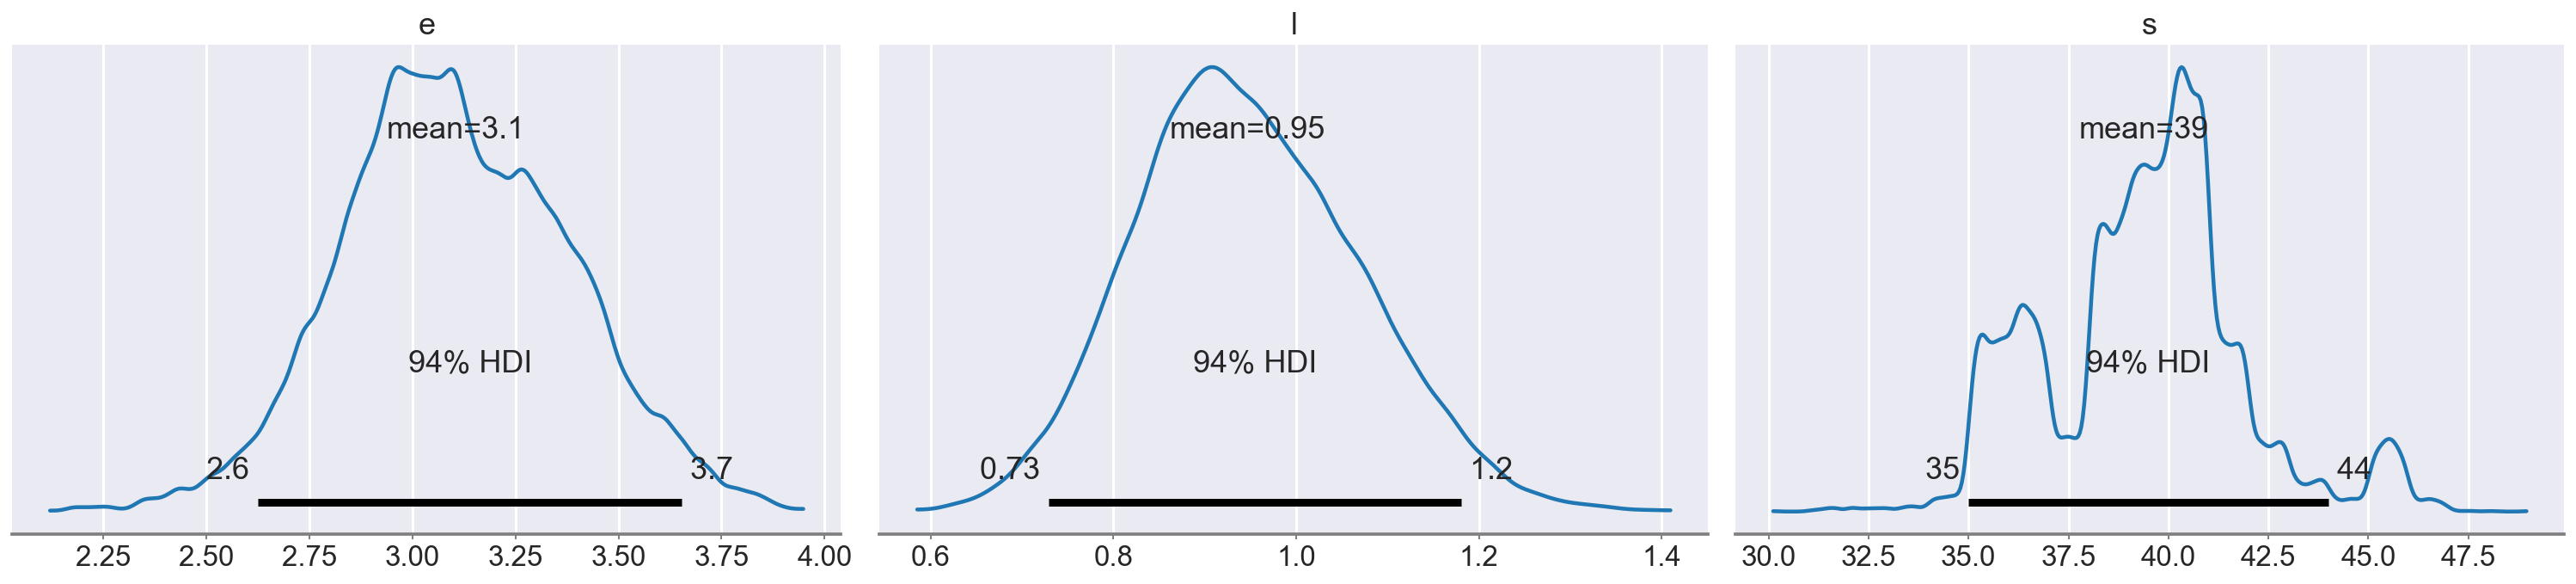

In [24]:
# 参考　： 事後分布の可視化　(plot_traceとsummaryで出力される情報をまとめて可視化)

az.plot_posterior(trace)

In [25]:
e_eap, l_eap, s_eap = [tf.reduce_mean(s) for s in states]
r_t_eap = tf.where(np.arange(len(years)) < s_eap, e_eap, l_eap)

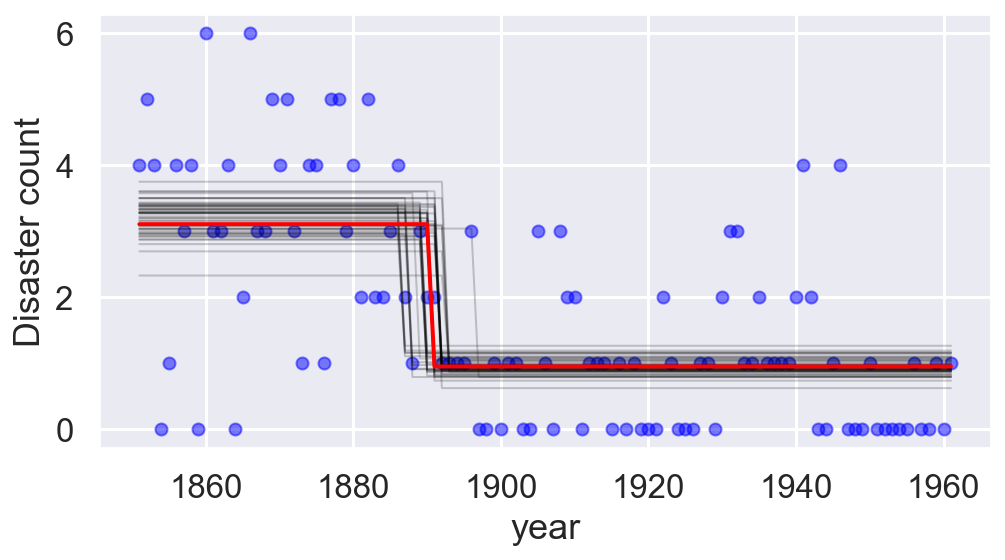

In [27]:
rates = tf.where(np.arange(len(years)) < tf.reshape(states[2], [-1, 1]), tf.reshape(states[0], [-1, 1]), tf.reshape(states[1], [-1, 1]))

plt.figure(figsize=(8, 4))
plt.plot(years, disaster_data, "o", color="b", markersize=6, alpha=0.5)
plt.ylabel("Disaster count")
plt.xlabel("year")


#事後分布からのサンプルを５０個取得し、ポアソン分布の平均値を描いてみる

rates = tf.random.shuffle(rates)
for i in range(50):
    plt.plot(years, rates[i], lw=1, alpha=0.2, color="k")
#EAP推定量
plt.plot(years, r_t_eap, lw=2, color="r")

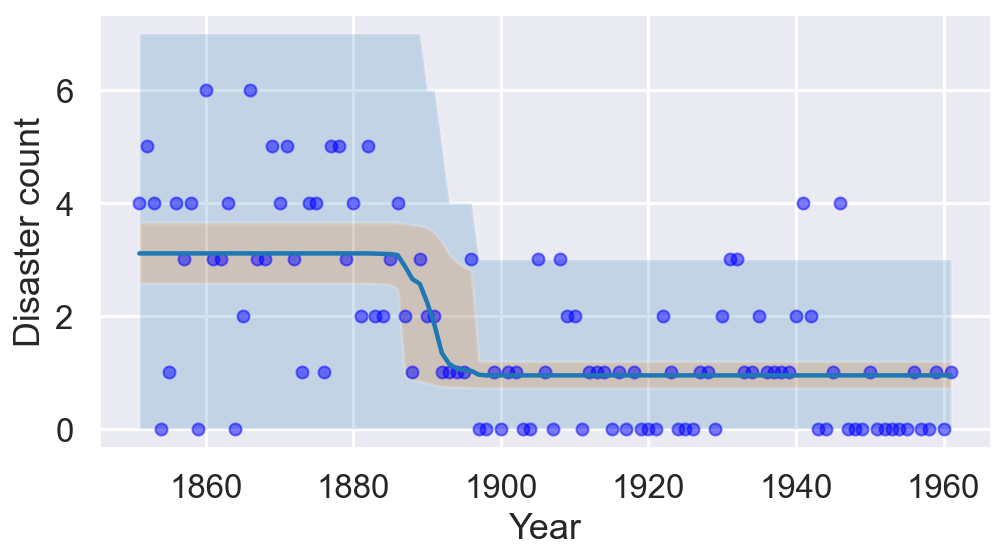

In [28]:
# 参考：r_t, D_tの95%区間を描画
samples = tfd.Poisson(rate=rates).sample()
obs_low, obs_high = np.percentile(samples, [2.5, 97.5], axis=0)
rates_low, rates_high = np.percentile(rates, [2.5, 97.5], axis=0)
means = np.mean(rates, axis=0)

plt.figure(figsize=(8, 4))
plt.plot(years, disaster_data, "o", color='b', markersize=6, alpha=0.5)
plt.ylabel("Disaster count")
plt.xlabel("Year")
plt.plot(years, means)
plt.fill_between(years, obs_low, obs_high, alpha=0.2)
plt.fill_between(years, rates_low, rates_high, alpha=0.2)